# Theory


We imagine a collection of Erdos-Renyi Random Graphs.

Want to calculate the probability distribution of the distribution of infecteds $x$ among the different graphs, given the overall fraction of infected $y$.

If we let $x_i$ be the fraction of infecteds in subgraph $i$, we expect a universal probability distribution $P(x_i | y)$. Due to symmetry, we further expect $P(x_i | y) = P(x|y)$ to be independent of $i$.

If we assume stationarity, we can find an equilibrium distribution $P(x | y)$. I.e. we assume an overal prevalence $y$ of infecteds, and conditioned on this $y$ find which stationary distribution of $x$ emerges.

Given $P(x | y)$ we can calculate $<x>$ and $<x^2>$, which gives us an $s_{eff}(x)$ in each of the subgraphs. 

We expect $x$ to be concentrated as $y$ is small, and then we expect it to gradually spread out as $y$ becomes larger.

## Stationary Distribution $P(x | y)$

Assume we have a regular two-level erdos-renyi graph with N total nodes. There are $n$ subgraphs of $m$ nodes each. Each node has $r$ connections randomly among all other subgraphs and $l$ connections randomly among its own subgraph.

We assume that for each individual independently

$$P_{death} \sim N \bar{y} (1 - y) (1 + \beta)$$
$$P_{birth} \sim N y (1 - \bar{y}) (1 + \alpha y)$$

$y$ stands for the local density, whereas $\bar{y}$ stands for the average density throughout the entire graph.
The $y (1 - y)$ terms arise in different ways. In the death process, we require an infected to die ($\bar{y}$) pick the type (infected or susceptible) from a random neighbor upon death ($1 - y$). For the birth process, we need to be susceptible ($1 - \bar{y}$) in order to undergo birth in the first place. However we have an independent probability from each neighbor of being infected ($y$). If we want to find the expectation of these quantities, we need

$$N_{death} \sim N \bar{y} (1 - <y>) (1 + \beta)$$
$$N_{birth} \sim N (1 - \bar{y}) (<y> + \alpha <y^2>)$$

per individual, we have

$$P_{death} \sim (1 - <y>) (1 + \beta)$$
$$P_{birth} \sim (<y> + \alpha <y^2>)$$

Due to the nonlinearity, we need the expectation of $<y^2>$ as well.

Now describe our system by a vector $\vec{a} = (a_0, a_1, ... , a_m)$ Where $a_j$ describes the number of subgraphs with $j$ infecteds. We of course only have $n$ subnodes, which requires
$$\sum_{j = 0}^m a_j = n $$
Since we must have $N y$ infecteds total, this requires a normalization
$$\sum_{j = 0}^m j a_j = N y$$

We imagine a stationary process where we randomly remove one infected individual and then randomly add one infected invidual. This process should relax to an equilibrium distribution

### Transition probabilities

Let us consider a node in a subgraph with $j$ total infecteds. This node has degree $r + l$. Let us find out $y$. We know inside the subgraph the prevalence is $\frac{j}{m}$. Outside, the prevalence is $\bar{y}$. Thus, we have $y = \frac{i_r + i_l}{r + l}$, where $i_r$ and $i_l$ are binomially distributed random variables:
$$i_l \sim Binom(l,\frac{j}{m})$$
$$i_r \sim Binom(r,\bar{y})$$

With means $<i_l> = \frac{l j}{m}$ and $<i_r> = r \bar{y}$. Thus we have $$y_{local} = y = \frac{l \frac{j}{m} +r \bar{y}}{l  + r}$$
in expectation. If the nodes is itself infected, it is part of the $j$ nodes, so we would really have
$$y_{local} = y = \frac{l \frac{j-1}{m} +r \bar{y}}{l  + r}$$ in that case.

For $<y^2>$ we have 
$$<y^2> = \left< \frac{i_r^2 + i_r i_l + i_l^2}{(r + l)^2} \right> = 
\frac{<i_r^2> + <i_l^2> + <i_r><i_l>}{(r + l)^2} = \frac{r \bar{y} ((r - 1) \bar{y} + 1) + l \frac{j}{m}((l - 1) \frac{j}{m} + 1) + l r \frac{j}{m} \bar{y}}{(r + l)^2} $$

We have $Var[x] = E[x^2] - E[x]^2$ For the binomial distribution,
$E[x^2] = Var[x] + E[x]^2 = n p (1 - p)  + n^2 p^2 = n p ((n - 1) p + 1)$

Now consider an individual in a subgraph with $j$ infecteds. If he is infected, his probability of being removed ($a_j -= 1$, $a_{j - 1} += 1$)is

$$a_j j <P_{death,j}> =  a_j j (1 - <y_j>) (1 + \beta)$$

If he is susceptible, his probability of being added is

$$ a_j (m - j) <P_{birth,j}> = (<y_j> + \alpha <y_j^2>) $$

We develop a markov chain where we apply one birth and one death process simultaneously and then observe the resulting equilibrium distribution.

## TODO

- Run simulations of actual two-level Erdos-Renyi random graphs
- Compare these simulations with the stationary process and see if the observed distribution $P(x | y)$ matches.

In [1]:
push!(LOAD_PATH,pwd())
using StatsBase, PyPlot, Distributions, LightGraphs, TwoLevelGraphs

In [2]:

#implement the MCMC exploration of the state space

##TODO: successive steps, not same time steps.

function run_mcmc_transition(t::TwoLevel,death_fn::Function,birth_fn::Function,plotting=false)
    death_probs = zeros(t.m)
    birth_probs = zeros(t.m)

    #birth
    for j = 1:t.m
        birth_probs[j] = birth_fn(t,j)
    end
    
    birth_idx = StatsBase.sample(WeightVec(birth_probs))
    birth_at(t,birth_idx)
    
    #death
    for j = 1:t.m
        death_probs[j] = death_fn(t,j)
    end
    death_idx = StatsBase.sample(WeightVec(death_probs))
    death_at(t,death_idx)
    

#     semilogy(birth_probs/death_probs)
#     println(birth_probs)
#     println(death_probs)
end

function birth_at(t::TwoLevel,idx::Int)
    t.a[idx] -= 1
    t.a[idx+1] += 1
end

function death_at(t::TwoLevel,idx::Int)
    t.a[idx+1] -= 1
    t.a[idx] += 1
end

function birth_fn(t::TwoLevel,j::Int,alpha=1.0)
    number_weight = birth_get_number_weight(t,j)
    
    y_global = t.i/t.N
    y_local = (t.l*j/t.m + r*y_global)/(t.r + t.l)
    y_squared_local = (t.r*y_global*((t.r - 1)* y_global + 1) + t.l*j/t.m*((t.l - 1)*j/t.m + 1) + t.l* t.r* j/t.m* y_global)/(t.r + t.l)^2 
    
    return number_weight*(y_local + alpha*y_squared_local)
    
end
    
function death_fn(t::TwoLevel,j::Int,beta=0.1)
    number_weight = death_get_number_weight(t,j)
    y_global = t.i/t.N
    y_local = (t.l*(j-1)/t.m + r*y_global)/(t.r + t.l)
    
    return number_weight*(1 - y_local)*(1 + beta)
    
end

function birth_get_number_weight(t::TwoLevel,j::Int)
    return t.a[j]*(t.m-(j-1))
end

function death_get_number_weight(t::TwoLevel,j::Int)
    return t.a[j+1]*(j)
end



death_get_number_weight (generic function with 1 method)

In [24]:
k = 4
#y_n = 0.1
c_r = 0.18
N = 400
n_n = 10#y_n*N
beta = 4.0/(c_r*n_n)
alpha = (N*beta)/n_n
println("N=$N, alpha = $alpha, beta = $beta")


#Generate a random startin vector
m = 40
n = Int(N/m)
l = Int(m/2)#internal
r = 4#Int(m/2)#2 #external

t = TwoLevel(N,m,l,r)

y_desired = 0.1
#distribute_randomly(t,n)
t.a[max(1,Int(round(y_desired*t.m)))] = t.n
make_consistent(t)
i = get_num_infected(t)
println(t.a," ", sum(t.a))
println(t.i/t.N)
is_valid(t)

N=400, alpha = 88.88888888888889, beta = 2.2222222222222223


true

[0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] 10
0.075


TwoLevelGraphs.

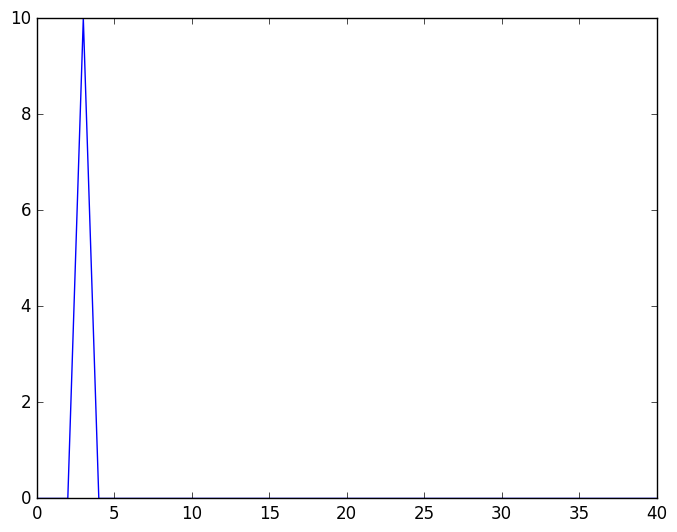

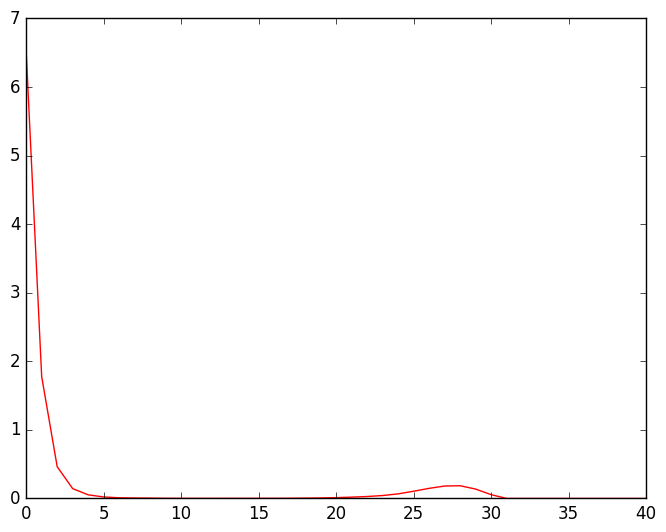

TwoLevel([9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],400,40,10,30,4,20)


In [25]:
accum = zeros(t.a)
dfn(x) = 1
bfn(x) = 1
plot(t.a)
num_trials = 100000
for i = 1:num_trials
    run_mcmc_transition(t,((x,y) -> death_fn(x,y,beta)),((x,y) -> birth_fn(x,y,alpha)),true)
accum += t.a
end
accum /= num_trials
figure()
plot(accum,"r")
# accum *= 0
# for i = 1:num_trials
#     run_mcmc_transition(t,death_get_number_weight,birth_get_number_weight)
# accum += t.a
# end
# accum /= num_trials
# plot(accum,"g")
# accum *= 0
# for i = 1:num_trials
#     run_mcmc_transition(t,((x,y) -> death_fn(x,y,beta)),((x,y) -> birth_fn(x,y,alpha)))
# accum += t.a
# end
# accum /= num_trials
# plot(accum,"k")
println(t)


Simulation Strategy: first burn in the distribution with neutral transition probabilities to sample different starting configurations. Then apply real transition functions to sample the distribution.

## Graph generation

We wish to generate two-level Erdos-Renyi random graphs. The central idea is that each individual subgraph is a simple ER random graph. These can be produced independently. Moreover, we can then view each subgraph as a supernode and produce another ER random graph connecting these super nodes with the appropriate amount of edges. In the final step we then uniformly distribute the edges between the super nodes among the actual nodes that make up the super nodes.

In [16]:
@time println(TwoLevelGraph(t).g)
@time LightGraphs.erdos_renyi(N,Int(N*(l+r)/2))


{400, 7995} undirected graph


{400, 8000} undirected graph

  0.015545 seconds (148.29 k allocations: 9.089 MB)
  0.007473 seconds (36.15 k allocations: 2.018 MB)


In [74]:
rand(Binomial(5,0.2))

1

In [59]:
cs,_ = make_two_level_random_graph(t)
#println(sort(sample_in_edges(cs,11,39)))
#println(sample_out_edges(cs,11,40))
println(degree(cs),mean(degree(cs)))
for i in 1:t.N
    println("i: $i, $(neighbors(cs,i)))")
end

[38,45,35,42,41,36,36,40,45,41,33,34,50,44,45,43,41,41,48,40,48,35,38,43,40,34,42,45,37,40,42,34,36,35,47,35,34,36,34,36,34,40,35,44,32,41,30,44,40,39,38,47,55,41,42,42,40,36,40,36,47,43,34,39,44,39,35,55,42,40,43,40,38,38,38,29,50,41,28,34,47,38,36,46,39,34,39,43,37,39,30,32,43,37,37,38,33,38,44,44,38,36,37,39,34,42,40,39,45,34,41,42,40,33,40,29,43,39,36,27,38,43,39,37,35,47,41,42,45,51,35,32,43,40,38,42,37,41,38,39,39,40,33,40,41,40,41,42,49,44,35,31,43,32,39,31,43,40,37,29,37,45,31,45,36,39,41,52,41,44,33,41,38,39,35,47,34,32,43,45,44,34,33,42,40,37,37,38,31,39,41,41,43,43,38,33,48,47,36,31,44,40,41,55,33,37,43,46,38,44,36,51,39,46,42,35,40,33,50,31,42,38,41,38,37,35,45,47,50,43,50,37,40,40,39,27,33,47,40,28,42,45,36,43,31,41,44,42,33,40,33,31,35,38,46,43,38,38,50,42,39,38,38,30,42,34,40,33,41,39,41,45,39,36,31,37,41,43,39,26,35,41,36,44,36,43,32,44,44,33,33,44,40,37,48,36,35,30,37,43,38,26,35,44,41,43,45,46,38,44,37,45,40,32,37,33,37,45,36,31,38,39,37,48,35,39,43,54,41,38,37,46,47,

In [92]:
cs = make_two_level_random_graph(t)

3 

({20, 24} undirected graph,[[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16],[17,18,19,20]])

6 0.3333333333333333
2 6 0.3333333333333333
3 6 0.3333333333333333
4 6 0.3333333333333333
4 6 0.3333333333333333


In [142]:
intersect([1,2,3],[3,4,5])

1-element Array{Int64,1}:
 3

In [90]:
splice!([1,2,3],2)

2

# Questions

## What do we do with knowledge of $P(x | y)$? How do we calculate the dynamics from there
## Make sure we have factors of $y (1 - y)$ correctly
## what are we using as the transition probabilities? Should we just average over all possible values of $i_r$ and $i_l$?


# TODO

## Have simulations output a detailed history of which node was infected at what time. That can be used to find the prevalence in each community, given the clusters.

## Implement a version with binomial sampling of edges intra-nodes and inter-nodes (so the numbers are not exact)